Generate a PNG of binned (0.1 m/z) raw data for a single frame

In [61]:
import sqlite3
import pandas as pd
import numpy as np
import sys

In [62]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [63]:
MS1_CE = 10

In [64]:
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [65]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [66]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [67]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [68]:
frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
frame_delay

1.1810854877303427

In [69]:
len(ms1_frame_properties_df)

203

In [70]:
RAW_FRAME_ID = 40411
RAW_FRAME_RT = ms1_frame_properties_df[ms1_frame_properties_df.frame_id == RAW_FRAME_ID].retention_time_secs.values[0]

In [71]:
MZ_MIN = 100.0
MZ_MAX = 1700.0
MZ_BIN_WIDTH = 0.1
SCAN_MIN = 1
SCAN_MAX = 910

In [72]:
mz_bins = np.arange(start=MZ_MIN, stop=MZ_MAX+MZ_BIN_WIDTH, step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value


In [73]:
mz_bins

array([ 100. ,  100.1,  100.2, ..., 1699.8, 1699.9, 1700. ])

In [74]:
MZ_BIN_COUNT = len(mz_bins)
MZ_BIN_COUNT

16001

Populate the intensity array with points from the raw frame

In [75]:
# load the raw frame points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(RAW_FRAME_ID), db_conn)
db_conn.close()

In [76]:
raw_points_df.intensity.max()

11145

In [77]:
len(raw_points_df)

268542

In [78]:
%%time
intensity_array = np.zeros([SCAN_MAX, MZ_BIN_COUNT], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
for r in zip(raw_points_df.mz,raw_points_df.scan,raw_points_df.intensity):
    mz = r[0]
    scan = int(r[1])
    if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
        mz_array_idx = int(np.digitize(mz, mz_bins))-1 # in which bin should this mz go
        scan_array_idx = scan
        intensity = int(r[2])
        intensity_array[scan_array_idx,mz_array_idx] += intensity
        

CPU times: user 4.12 s, sys: 27.9 ms, total: 4.15 s
Wall time: 4.04 s


In [79]:
intensity_array.max()

13128

In [80]:
DELTA_MZ = 1.003355     # Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.

In [81]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

Process the allpeptides file to get the MQ features

In [82]:
MIN_ISOTOPE_CORRELATION = 0.9

allpeptides_df = pd.read_csv(ALLPEPTIDES_FILENAME, sep='\t')
allpeptides_df.rename(columns={'Number of isotopic peaks':'isotope_count', 'm/z':'mz', 'Number of data points':'number_data_points', 'Intensity':'intensity', 'Ion mobility index':'scan', 'Ion mobility index length':'scan_length', 'Ion mobility index length (FWHM)':'scan_length_fwhm', 'Retention time':'rt', 'Retention length':'rt_length', 'Retention length (FWHM)':'rt_length_fwhm', 'Charge':'charge_state', 'Number of pasef MS/MS':'number_pasef_ms2_ids', 'Isotope correlation':'isotope_correlation'}, inplace=True)
allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull()].copy()  # remove all the null intensity rows
allpeptides_df = allpeptides_df[allpeptides_df.intensity.notnull() & (allpeptides_df.isotope_correlation >= MIN_ISOTOPE_CORRELATION) & (allpeptides_df.rt >= RT_LIMIT_LOWER) & (allpeptides_df.rt <= RT_LIMIT_UPPER)].copy()

# use the feature's FWHM in RT
allpeptides_df["rt_delta"] = allpeptides_df.rt_length_fwhm / 2
allpeptides_df["rt_lower"] = allpeptides_df.rt - allpeptides_df.rt_delta
allpeptides_df["rt_upper"] = allpeptides_df.rt + allpeptides_df.rt_delta

# sort the features by decreasing intensity and give them an ID
allpeptides_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_df)+1)


In [83]:
print("charge states: {} to {}".format(allpeptides_df.charge_state.min(), allpeptides_df.charge_state.max()))

charge states: 1 to 4


Calculate the binned rectangle coordinates for all the MQ features

In [84]:
len(allpeptides_df)

11524

In [85]:
mz_ppm_tolerance_l = []
binned_mz_lower_l = []
binned_mz_upper_l = []
binned_mz_idx_lower_l = []
binned_mz_idx_upper_l = []
scan_lower_l = []
scan_upper_l = []

# calculate the MQ feature rectangles
for r in zip(allpeptides_df.mq_feature_id,allpeptides_df.charge_state,allpeptides_df.isotope_count,allpeptides_df.mz,allpeptides_df.scan,allpeptides_df.scan_length):
    mq_feature_id = int(r[0])
    charge_state = int(r[1])
    isotope_count = int(r[2])
    mq_feature_mz = r[3]
    mq_feature_scan = int(r[4])
    mq_feature_scan_length = int(r[5])

    expected_isotope_spacing_mz = DELTA_MZ / charge_state

    # determine the bounding box coordinates for m/z and scan in real space
    mz_ppm_tolerance = mq_feature_mz * MZ_TOLERANCE_PERCENT / 100
    mz_ppm_tolerance_l.append((mz_ppm_tolerance))
    
    # find the bin edges for the feature's mz
    binned_mz_idx_lower = int(np.digitize(mq_feature_mz, mz_bins))-1
    binned_mz_idx_upper = int(np.digitize(mq_feature_mz + ((isotope_count-1) * expected_isotope_spacing_mz), mz_bins))
    rect_mz_lower = mz_bins[binned_mz_idx_lower]
    rect_mz_upper = mz_bins[binned_mz_idx_upper]
    rect_mz_range = rect_mz_upper - rect_mz_lower
    binned_mz_lower_l.append(rect_mz_lower)
    binned_mz_upper_l.append(rect_mz_upper)
    binned_mz_idx_lower_l.append(binned_mz_idx_lower)
    binned_mz_idx_upper_l.append(binned_mz_idx_upper)

    rect_scan = mq_feature_scan
    rect_scan_delta = mq_feature_scan_length / 2
    rect_scan_lower = int(rect_scan - rect_scan_delta)
    rect_scan_upper = int(rect_scan + rect_scan_delta)
    rect_scan_range = int(mq_feature_scan_length)
    scan_lower_l.append(rect_scan_lower)
    scan_upper_l.append(rect_scan_upper)
    
allpeptides_df['mz_ppm_tolerance'] = mz_ppm_tolerance_l
allpeptides_df['binned_rect_mz_lower'] = binned_mz_lower_l
allpeptides_df['binned_rect_mz_upper'] = binned_mz_upper_l
allpeptides_df['binned_rect_mz_idx_lower'] = binned_mz_idx_lower_l
allpeptides_df['binned_rect_mz_idx_upper'] = binned_mz_idx_upper_l
allpeptides_df['scan_lower'] = scan_lower_l
allpeptides_df['scan_upper'] = scan_upper_l


In [86]:
# for display, use the features that overlap with this frame
allpeptides_subset_df = allpeptides_df[(allpeptides_df.rt_lower <= RAW_FRAME_RT) & (allpeptides_df.rt_upper >= RAW_FRAME_RT)].copy()
print("there are {} MQ features overlapping this frame".format(len(allpeptides_subset_df)))


there are 227 MQ features overlapping this frame


In [87]:
allpeptides_subset_df[['mz','binned_rect_mz_lower','binned_rect_mz_upper','binned_rect_mz_idx_lower','binned_rect_mz_idx_upper']].head()

,mz,binned_rect_mz_lower,binned_rect_mz_upper,binned_rect_mz_idx_lower,binned_rect_mz_idx_upper
235967,781.34758,781.3,783.9,6813,6839
267086,855.43633,855.4,861.5,7554,7615
166662,662.68279,662.6,665.1,5626,5651
233967,773.90570,773.9,776.5,6739,6765
298665,1001.47410,1001.4,1004.0,9014,9040


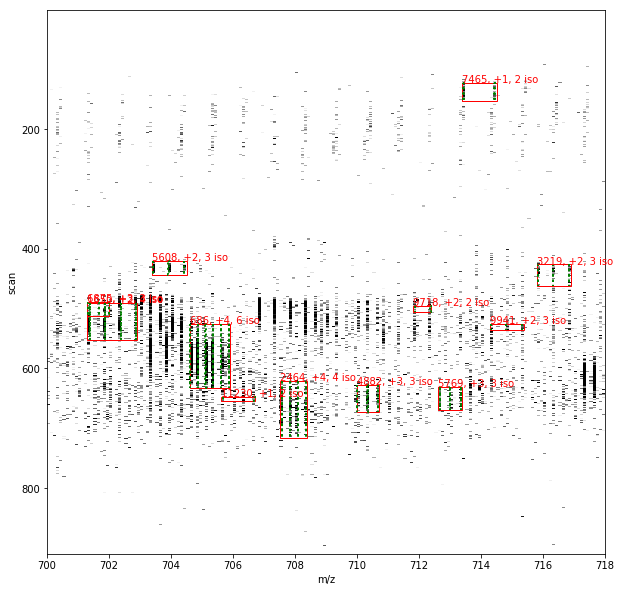

In [88]:
# overlay the image with MQ feature locations
import matplotlib.patches as patches
from matplotlib import colors, cm, pyplot as plt

# the m/z range to display
mz_display_lower = 700
mz_display_upper = 718

# the scan range to display
scan_display_lower = 1
scan_display_upper = 910

mz_display_idx_lower = int(np.digitize(mz_display_lower, mz_bins))-1
mz_display_idx_upper = int(np.digitize(mz_display_upper, mz_bins))-1

f, ax1 = plt.subplots()

f.set_figheight(10)
f.set_figwidth(10)

plt.xlabel('m/z')
plt.ylabel('scan')
plt.margins(0.06)

# show the image
cmap = cm.get_cmap('gist_yarg')
# cmap = cm.get_cmap('PuRd')
cmap_value_lower = 1
cmap_value_upper = 150
ax1.imshow(intensity_array[scan_display_lower:scan_display_upper,mz_display_idx_lower:mz_display_idx_upper], cmap=cmap, norm=colors.Normalize(vmin=cmap_value_lower, vmax=cmap_value_upper, clip=True), interpolation='none', aspect='auto', extent=[mz_display_lower,mz_display_upper,scan_display_upper,scan_display_lower])

# overlay the MQ feature rectangles
ap_df = allpeptides_subset_df
for r in zip(ap_df.mq_feature_id,ap_df.mz,ap_df.charge_state,ap_df.isotope_count,ap_df.binned_rect_mz_lower,ap_df.binned_rect_mz_upper,ap_df.scan_lower,ap_df.scan_upper,ap_df.mz_ppm_tolerance):
    mq_feature_id = int(r[0])
    mq_feature_mz = r[1]
    charge_state = int(r[2])
    isotope_count = int(r[3])

    expected_isotope_spacing_mz = DELTA_MZ / charge_state

    # determine the bounding box coordinates for m/z and scan in real space
    rect_mz_lower = r[4]
    rect_mz_upper = r[5]
    rect_mz_range = rect_mz_upper - rect_mz_lower

    rect_scan_lower = int(r[6])
    rect_scan_upper = int(r[7])
    rect_scan_range = rect_scan_upper - rect_scan_lower
    
    # draw the rectangle for the feature's extent
    mq_feature_rect = patches.Rectangle((rect_mz_lower,rect_scan_lower),rect_mz_range,rect_scan_range,linewidth=1,linestyle='-',edgecolor='r',facecolor='none', label='feature')
    ax1.add_patch(mq_feature_rect)

    # draw the isotopes
    mz_ppm_tolerance = r[8]
    isotope_base_mz_lower = mq_feature_mz - mz_ppm_tolerance
    isotope_base_mz_upper = mq_feature_mz + mz_ppm_tolerance
    for isotope_idx in range(0,isotope_count):
        isotope_mz_lower = isotope_base_mz_lower + (isotope_idx * expected_isotope_spacing_mz)
        isotope_mz_upper = isotope_base_mz_upper + (isotope_idx * expected_isotope_spacing_mz)
        isotope_rect = patches.Rectangle((isotope_mz_lower,rect_scan_lower),isotope_mz_upper-isotope_mz_lower,rect_scan_range,linewidth=2,linestyle=':',edgecolor='g',facecolor='none', label='isotope')
        ax1.add_patch(isotope_rect)
    
    # draw the feature label
    text_style = dict(size=10, color='red')
    text_x = rect_mz_lower
    text_y = rect_scan_lower-0.5
    if (text_x >= mz_display_lower) and (text_x <= mz_display_upper) and (text_y >= scan_display_lower) and (text_y <= scan_display_upper):
        ax1.text(text_x, text_y, "{}, +{}, {} iso".format(mq_feature_id,charge_state,isotope_count), **text_style)



In [89]:
PIXELS_PER_MZ_BIN = 5
PIXELS_PER_SCAN = 1

In [90]:
# will stretch the image to these dimensions
TILE_HEIGHT = SCAN_MAX
TILE_WIDTH = TILE_HEIGHT

In [91]:
PIXELS_X = MZ_BIN_COUNT * PIXELS_PER_MZ_BIN
PIXELS_Y = SCAN_MAX * PIXELS_PER_SCAN
MZ_BINS_PER_TILE = int(TILE_WIDTH / PIXELS_PER_MZ_BIN)
TILES_PER_FRAME = int(MZ_BIN_COUNT / MZ_BINS_PER_TILE)
RESIZE_FACTOR_X = TILE_WIDTH / MZ_BINS_PER_TILE


In [92]:
RESIZE_FACTOR_X

5.0

In [93]:
MZ_BINS_PER_TILE

182

In [94]:
TILES_PER_FRAME

87

In [95]:
# convert the intensity array to an image
df = pd.DataFrame(intensity_array).stack().rename_axis(['y', 'x']).reset_index(name='intensity')

# remove all the zero-intensity elements
df = df[df.intensity > 0]

In [96]:
len(df)

239199

In [97]:
df.head()

,y,x,intensity
546133,34,2099,79
553355,34,9321,9
573658,35,13623,9
575793,35,15758,9
578473,36,2437,136


In [98]:
intensity_array.max()

13128

In [99]:
norm=colors.Normalize(vmin=intensity_array.min(), vmax=intensity_array.max(), clip=False)
cmap = cm.get_cmap('magma')
print(cmap(norm(intensity_array.max()), bytes=True))

(251, 252, 191, 255)


In [100]:
def convert_to_colour(normed_intensity):
    return cmap(normed_intensity, bytes=True)[:3]

In [101]:
%%time
colour_l = []
for r in zip(df.intensity):
    colour_l.append((convert_to_colour(r[0])))
df['colour'] = colour_l

CPU times: user 3.95 s, sys: 29.9 ms, total: 3.98 s
Wall time: 4.01 s


In [102]:
df.head()

,y,x,intensity,colour
546133,34,2099,79,"(104, 27, 128)"
553355,34,9321,9,"(4, 3, 19)"
573658,35,13623,9,"(4, 3, 19)"
575793,35,15758,9,"(4, 3, 19)"
578473,36,2437,136,"(195, 59, 116)"


In [103]:
im_array = np.zeros([TILE_HEIGHT, MZ_BIN_COUNT, 3], dtype=np.uint8)  # container for the image
im_array[:] = 255 # fill it

In [104]:
%%time
for r in zip(df.x, df.y, df.colour):
    x = r[0]
    y = r[1]
    c = r[2]
    im_array[y,x,:] = c

CPU times: user 459 ms, sys: 3.96 ms, total: 463 ms
Wall time: 465 ms


In [105]:
im_array.max()

255

Generate tiles for all frames

In [106]:
TILE_BASE = '/Users/darylwilding-mcbride/Downloads/yolo-train'
PRE_ASSIGNED_FILES_DIR = '{}/pre-assigned'.format(TILE_BASE)
OVERLAY_FILES_DIR = '{}/overlay'.format(TILE_BASE)

In [107]:
import os, shutil

# initialise the directories required for the data set creation
if os.path.exists(TILE_BASE):
    shutil.rmtree(TILE_BASE)
os.makedirs(TILE_BASE)

if os.path.exists(PRE_ASSIGNED_FILES_DIR):
    shutil.rmtree(PRE_ASSIGNED_FILES_DIR)
os.makedirs(PRE_ASSIGNED_FILES_DIR)

if os.path.exists(OVERLAY_FILES_DIR):
    shutil.rmtree(OVERLAY_FILES_DIR)
os.makedirs(OVERLAY_FILES_DIR)


In [108]:
MAX_CHARGE_STATE = int(allpeptides_df.charge_state.max())

In [109]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# count the instances by class
instances_df = pd.DataFrame([(x,0) for x in range(1,MAX_CHARGE_STATE+1)], columns=['charge','instances'])

for frame_r in zip(ms1_frame_properties_df.frame_id, ms1_frame_properties_df.retention_time_secs):
# for frame_r in zip(ms1_frame_properties_df.iloc[:1].frame_id, ms1_frame_properties_df.iloc[:1].retention_time_secs):
    frame_id = int(frame_r[0])
    frame_rt = frame_r[1]
    
    # get the features overlapping this frame
    allpeptides_frame_overlap_df = allpeptides_df[(allpeptides_df.rt_lower <= frame_rt) & (allpeptides_df.rt_upper >= frame_rt)].copy()

    # load the raw frame points
    db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
    raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(frame_id), db_conn)
    db_conn.close()
    
    # convert the raw points to an intensity array
    frame_intensity_array = np.zeros([SCAN_MAX+1, MZ_BIN_COUNT+1], dtype=np.uint16)  # scratchpad for the intensity value prior to image conversion
    for r in zip(raw_points_df.mz,raw_points_df.scan,raw_points_df.intensity):
        mz = r[0]
        scan = int(r[1])
        if (mz >= MZ_MIN) and (mz <= MZ_MAX) and (scan >= SCAN_MIN) and (scan <= SCAN_MAX):
            mz_array_idx = int(np.digitize(mz, mz_bins))-1
            scan_array_idx = scan
            intensity = int(r[2])
            frame_intensity_array[scan_array_idx,mz_array_idx] += intensity

    # convert the intensity array to a dataframe
    intensity_df = pd.DataFrame(frame_intensity_array).stack().rename_axis(['y', 'x']).reset_index(name='intensity')
    # remove all the zero-intensity elements
    intensity_df = intensity_df[intensity_df.intensity > 0]
    # calculate the colour to represent the intensity
    norm = colors.Normalize(vmin=frame_intensity_array.min(), vmax=frame_intensity_array.max(), clip=False)
    colour_l = []
    for r in zip(intensity_df.intensity):
        colour_l.append((convert_to_colour(normed_intensity=norm(r[0]))))
    intensity_df['colour'] = colour_l

    # create an image of the whole frame
    frame_im_array = np.zeros([TILE_HEIGHT+1, MZ_BIN_COUNT+1, 3], dtype=np.uint8)  # container for the image
    frame_im_array[:] = 255
    for r in zip(intensity_df.x, intensity_df.y, intensity_df.colour):
        x = r[0]
        y = r[1]
        c = r[2]
        frame_im_array[y,x,:] = c

    # write out the image tiles for the frame
    for tile_idx in range(TILES_PER_FRAME):
        # tile m/z coordinates
        tile_base_mz = mz_bins[tile_idx * MZ_BINS_PER_TILE]
        tile_width_mz = MZ_BINS_PER_TILE * MZ_BIN_WIDTH
        # tile index coordinates
        tile_idx_base = int(tile_idx * MZ_BINS_PER_TILE)
        tile_idx_width = MZ_BINS_PER_TILE
        # extract the subset of the frame for this image
        tile_im_array = frame_im_array[:,tile_idx_base:tile_idx_base+tile_idx_width,:]
        tile = Image.fromarray(tile_im_array, 'RGB')
        tile_with_overlay = Image.fromarray(tile_im_array, 'RGB')

        # stretch the image to be square
        stretched_tile = tile.resize((TILE_WIDTH, TILE_HEIGHT))
        stretched_tile_with_overlay = tile_with_overlay.resize((TILE_WIDTH, TILE_HEIGHT))

        # get the MQ features that fully fit in the tile
        feature_coordinates = []
        ap_df = allpeptides_frame_overlap_df
        for feature_r in zip(ap_df.mq_feature_id, ap_df.mz, ap_df.charge_state, ap_df.isotope_count, ap_df.binned_rect_mz_idx_lower, ap_df.binned_rect_mz_idx_upper, ap_df.scan_lower, ap_df.scan_upper):
            mq_feature_id = int(feature_r[0])
            mq_feature_mz = feature_r[1]
            mq_feature_charge_state = int(feature_r[2])
            isotope_count = int(feature_r[3])
            binned_rect_mz_idx_lower = int(feature_r[4])
            binned_rect_mz_idx_upper = int(feature_r[5])
            scan_lower = int(feature_r[6])
            scan_upper = int(feature_r[7])

            # draw the MQ features overlay
            draw = ImageDraw.Draw(stretched_tile_with_overlay)
            x0 = (binned_rect_mz_idx_lower - tile_idx_base) * RESIZE_FACTOR_X
            x1 = (binned_rect_mz_idx_upper - tile_idx_base) * RESIZE_FACTOR_X
            y0 = scan_lower
            y1 = scan_upper
            # text file coordinates
            x = (x0 + ((x1 - x0) / 2)) / TILE_WIDTH  # YOLO expects x,y to be the centre point of the object
            y = (y0 + ((y1 - y0) / 2)) / TILE_HEIGHT
            width = (x1 - x0) / TILE_WIDTH
            height = (y1 - y0) / TILE_HEIGHT
            object_class = mq_feature_charge_state-1
            # draw the MQ feature if its centre is within the tile
            if (((x-(width/2)) >= 0) and ((x+(width/2)) <= 1) and ((y-(height/2)) >= 0) and ((y+(height/2)) <= 1)):
                draw.rectangle(xy=[(x0, y0), (x1, y1)], fill=None, outline='red')
                draw.text((x0, y0-12), "{}, +{}, {} iso".format(mq_feature_id,mq_feature_charge_state,isotope_count), font=ImageFont.truetype('/Library/Fonts/Arial.ttf', 10), fill='red')
                feature_coordinates.append(("{} {:.6f} {:.6f} {:.6f} {:.6f}".format(object_class,x,y,width,height)))
                instances_df.loc[(instances_df.charge == mq_feature_charge_state),'instances'] += 1

        # write them out
        train_filename = '{}/frame-{}-tile-{}-mz-{}-{}.png'.format(PRE_ASSIGNED_FILES_DIR, frame_id, tile_idx, int(tile_base_mz), int(tile_base_mz+tile_width_mz))
        train_text_filename = '{}/frame-{}-tile-{}-mz-{}-{}.txt'.format(PRE_ASSIGNED_FILES_DIR, frame_id, tile_idx, int(tile_base_mz), int(tile_base_mz+tile_width_mz))
        overlay_filename = '{}/frame-{}-tile-{}-mz-{}-{}.png'.format(OVERLAY_FILES_DIR, frame_id, tile_idx, int(tile_base_mz), int(tile_base_mz+tile_width_mz))
        stretched_tile.save(train_filename)
        stretched_tile_with_overlay.save(overlay_filename)
        # write the text file
        with open(train_text_filename, 'w') as f:
            for item in feature_coordinates:
                f.write("%s\n" % item)

print("{}".format(instances_df))
print("total number of labelled instances: {}".format(instances_df.instances.sum()))

   charge  instances
0       1       9225
1       2      36127
2       3      17080
3       4       3402
total number of labelled instances: 65834


Split the tiles into training, test, validation sets

In [110]:
"{:.2f}".format(3.14235454)

'3.14'

In [111]:
# load the file names into a dataframe
import glob, os

filenames = []
for file in glob.glob("{}/*.png".format(PRE_ASSIGNED_FILES_DIR)):
    filenames.append((os.path.basename(os.path.splitext(file)[0])))

In [112]:
fn_df = pd.DataFrame(filenames, columns=['name'])

In [113]:
fn_df.head()

,name
0,frame-41027-tile-56-mz-1119-1137
1,frame-42358-tile-1-mz-118-136
2,frame-42523-tile-64-mz-1264-1282
3,frame-41005-tile-47-mz-955-973
4,frame-42314-tile-68-mz-1337-1355


In [114]:
def train_validate_test_split(df, train_percent=.9, validate_percent=.05, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test


In [115]:
train_df,validate_df,test_df = train_validate_test_split(fn_df)

In [116]:
print(len(train_df),len(validate_df),len(test_df))

15894 883 884


In [117]:
import shutil

data_dirs = ['train', 'validation', 'test']
data_dfs = [train_df, validate_df, test_df]


In [118]:
DESTINATION_DATASET_BASE = 'data/peptides'
LOCAL_DATA_FILES_DIR = '{}/data-files'.format(TILE_BASE)
DESTINATION_DATA_FILES_DIR = '{}/data-files'.format(DESTINATION_DATASET_BASE)
FILE_LIST_SUFFIX = 'list'

In [119]:
# initialise the directories required for the data set organisation
if os.path.exists(LOCAL_DATA_FILES_DIR):
    shutil.rmtree(LOCAL_DATA_FILES_DIR)
os.makedirs(LOCAL_DATA_FILES_DIR)


In [120]:
for idx,dd in enumerate(data_dirs):
    print("processing {}".format(dd))
    
    # initialise the directory for each set
    data_dir = "{}/{}".format(TILE_BASE, dd)
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    os.makedirs(data_dir)
    
    # create the prefix column
    data_dfs[idx]['text_entry'] = '{}/{}/'.format(DESTINATION_DATASET_BASE, dd) + data_dfs[idx].name + '.png'

    # copy the files into their respective directories
    for r in zip(data_dfs[idx].name):
        shutil.copyfile("{}/{}.png".format(PRE_ASSIGNED_FILES_DIR,r[0]), "{}/{}/{}.png".format(TILE_BASE, dd, r[0]))
        shutil.copyfile("{}/{}.txt".format(PRE_ASSIGNED_FILES_DIR,r[0]), "{}/{}/{}.txt".format(TILE_BASE, dd, r[0]))

    # generate the text files for each set
    data_dfs[idx].text_entry.to_csv("{}/{}-{}.txt".format(LOCAL_DATA_FILES_DIR, dd, FILE_LIST_SUFFIX), index=False, header=False)

processing train
processing validation
processing test


In [121]:
# create the names and data files for Darknet
LOCAL_NAMES_FILENAME = "{}/peptides-obj.names".format(TILE_BASE)
DESTINATION_NAMES_FILENAME = "{}/peptides-obj.names".format(DESTINATION_DATASET_BASE)
LOCAL_DATA_FILENAME = "{}/peptides-obj.data".format(TILE_BASE)

with open(LOCAL_NAMES_FILENAME, 'w') as f:
    for charge in range(1,MAX_CHARGE_STATE+1):
        f.write("charge-{}\n".format(charge))

print("finished writing {}".format(LOCAL_NAMES_FILENAME))

with open(LOCAL_DATA_FILENAME, 'w') as f:
    f.write("classes={}\n".format(MAX_CHARGE_STATE))
    f.write("train={}\n".format("{}/{}-{}.txt".format(DESTINATION_DATA_FILES_DIR, data_dirs[0], FILE_LIST_SUFFIX)))
    f.write("valid={}\n".format("{}/{}-{}.txt".format(DESTINATION_DATA_FILES_DIR, data_dirs[1], FILE_LIST_SUFFIX)))
    f.write("names={}\n".format(DESTINATION_NAMES_FILENAME))
    f.write("backup=backup/\n")

print("finished writing {}".format(LOCAL_DATA_FILENAME))


finished writing /Users/darylwilding-mcbride/Downloads/yolo-train/peptides-obj.names
finished writing /Users/darylwilding-mcbride/Downloads/yolo-train/peptides-obj.data
